### Importing Libraries

---

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Seaborn Style

---

In [2]:
sns.set_theme('paper')
sns.set_style('ticks')

### Adding `utils` to `PYTHONPATH`

---

In [3]:
sys.path.append(os.path.abspath("../utils"))

### Reading Parquet File

---

In [4]:
# Importing load_parquet function from read_data module
from read_data import load_parquet
cars = load_parquet('clean_data', 'clean_data_after_eda.parquet')
cars.head()

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
0,88760,Petrol,Manual,1st owner,219000,998,2012,Maruti,Wagon R 1.0
1,17920,Petrol,Manual,1st owner,266000,796,2016,Maruti,Alto 800
2,9940,Petrol,Manual,1st owner,496000,1373,2014,Maruti,Ertiga
3,67340,Petrol,Manual,2nd owner,355000,1199,2016,Tata,Tiago
4,30390,Petrol,Manual,1st owner,530000,998,2023,Maruti,New Wagon-R


In [5]:
# Since we have removed some data while exploratory data analysis,
# Some of the categories in categorical columns might got removed but the category will still be present
# Because we have converted object datatype into category datatype, so we have to remove these unused categories manually
cat_col = cars.select_dtypes(include='category').columns
for column in cat_col:
    cars[column] = cars[column].cat.remove_unused_categories()

### Handling High Cardinality Column  

---

In [6]:
# Frequency Distribution of "model" column
# As we can see, "model" column contains huge number of categories, which can cause problem when we apply OneHotEncoding on it
# It will create too many columns and cause sparsity (having too many zeros)
print(f'Unique categories in "model" column : {len(cars['model'].unique())}')

Unique categories in "model" column : 124


In [7]:
# So we are using model frequencies in place of original "model" column
model_freq = cars['model'].value_counts(normalize=True)

In [8]:
# Mapping model frequencies to "model" column
cars['model_freq'] = cars['model'].map(model_freq)

In [9]:
# Removing original "model" column
cars.drop('model', axis=1, inplace=True)

### Importing Libraries for Pipeline

---

In [10]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, KFold, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

### Creating Training and Testing Set

---

In [11]:
# Creating Features and Target Variable
X = cars.drop('price', axis=1)
y = cars['price']

In [12]:
# Splitting Data into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# Size of Training and Testing Set
print(f"Training Data : {X_train.shape[0]} | Testing Data : {X_test.shape[0]}")

Training Data : 1917 | Testing Data : 639


### Building Pipeline

---

#### Component for Nominal Column

In [14]:
nominal_cols = ['fuel_type','transmission','brand']

In [15]:
nominal_trf = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

#### Component for Ordinal Column

In [16]:
ordinal_cols = ['owner']

In [17]:
ordinal_categories = [['Others','3rd owner','2nd owner','1st owner']]

In [18]:
ordinal_trf = Pipeline(steps=[
    ('oe', OrdinalEncoder(categories=ordinal_categories))
])

#### Component for Numerical Column

In [20]:
numerical_cols = ['km_driven','year','engine_capacity']

In [21]:
numerical_trf = Pipeline(steps=[
    ('scaler', RobustScaler())
])

#### Adding Everything into ColumnTransformer

In [22]:
ctf = ColumnTransformer(transformers=[
    ('nominal', nominal_trf, nominal_cols),
    ('ordinal', ordinal_trf, ordinal_cols),
    ('scaling', numerical_trf, numerical_cols)
], remainder='passthrough', n_jobs=-1)

### Evaluating Multiple Models

---

In [24]:
# Importing Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [25]:
# Models Dictionary
models = {
    'LR' : LinearRegression(n_jobs=-1),
    'KNN' : KNeighborsRegressor(n_jobs=-1),
    'DT' : DecisionTreeRegressor(random_state=42),
    'RF' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'GB' : GradientBoostingRegressor(random_state=42),
    'XGB' : XGBRegressor(random_state=42, n_jobs=-1)
}

In [26]:
# Computing Average Error and R2-Score through Cross-Validation
results = {}

for name, model in models.items():
    
    pipe = Pipeline(steps=[
        ('preprocessor', ctf),
        ('model', model)
    ])

    k = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1, return_train_score=False)

    results[name] = {'avg_error': -cv_results['test_mae'].mean(),'avg_score': cv_results['test_r2'].mean()}

    print()
    print(f'Model : {name}')
    print('-'*40)
    print(f'Average Error : {-cv_results['test_mae'].mean():.2f}')
    print(f'Standard Deviation of Error : {cv_results['test_mae'].std():.2f}')
    print(f'Average R2-Score : {cv_results['test_r2'].mean():.2f}')
    print(f'Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}')


Model : LR
----------------------------------------
Average Error : 123190.02
Standard Deviation of Error : 6445.18
Average R2-Score : 0.77
Standard Deviation of R2-Score : 0.01

Model : KNN
----------------------------------------
Average Error : 115572.16
Standard Deviation of Error : 3883.19
Average R2-Score : 0.79
Standard Deviation of R2-Score : 0.00

Model : DT
----------------------------------------
Average Error : 118466.64
Standard Deviation of Error : 4490.62
Average R2-Score : 0.76
Standard Deviation of R2-Score : 0.03

Model : RF
----------------------------------------
Average Error : 90811.20
Standard Deviation of Error : 2335.09
Average R2-Score : 0.86
Standard Deviation of R2-Score : 0.01

Model : GB
----------------------------------------
Average Error : 98056.52
Standard Deviation of Error : 3001.29
Average R2-Score : 0.85
Standard Deviation of R2-Score : 0.01

Model : XGB
----------------------------------------
Average Error : 91595.94
Standard Deviation of Error

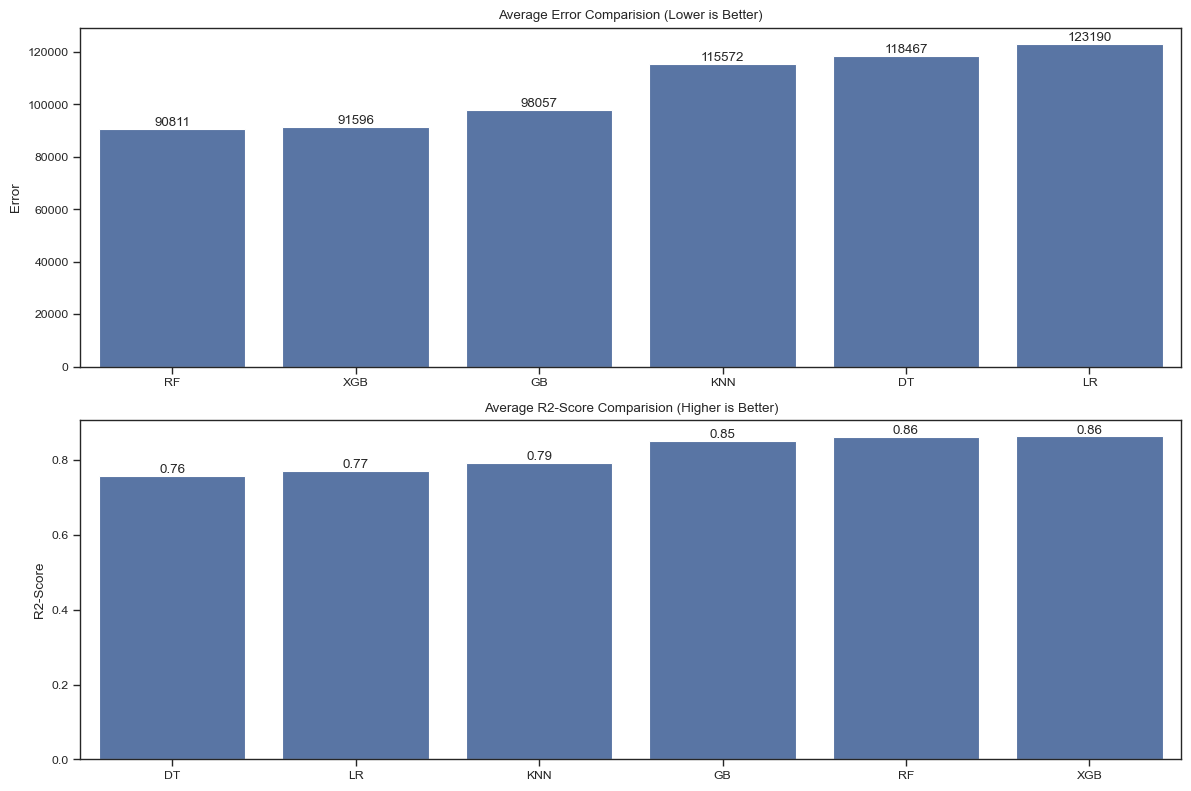

In [27]:
# Plotting Metric Comparision Graph
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

sns.barplot(x=results_df.iloc[0,:].sort_values().index.to_list(), y=results_df.iloc[0,:].sort_values().values, ax=ax[0])
ax[0].set_title('Average Error Comparision (Lower is Better)')
ax[0].set_ylabel('Error')
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f')

sns.barplot(x=results_df.iloc[1,:].sort_values().index.to_list(), y=results_df.iloc[1,:].sort_values().values, ax=ax[1])
ax[1].set_title('Average R2-Score Comparision (Higher is Better)')
ax[1].set_ylabel('R2-Score')
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

### Creating Stacking Regressor

---

- The above graph shows model performance based on average error (lower is better) and average R2-Score (higher is better).
- RandomForestRegressor, XGBRegressor and GradientBoostingRegressor are the top-performing models :
    - RF has the lowest error and highest R2-Score.
    - XGB and GB also closely follows with strong performance on both metrics.
- To leverage their strengths, I used (RF + XGB + GB) as base models in a StackingRegressor because :
    - RF handles non-linearities and interactions effectively.
    - XGB and GB excel in reducing bias and variance, boosting predictive power.
    - Combining these models captures a wider range of patterns in the data.
- ElasticNet is used as the final estimator because :
    - It combines L1 and L2 regularization, improving generalization and reducing overfitting.
- This stacked approach results in a more robust and accurate predictive model.

In [28]:
# Creating Object of the Models
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, n_jobs=-1)
meta_model = ElasticNet(max_iter=10000, random_state=42)

In [29]:
# Assigning Base Model for StackingRegressor
base_model = [('rf', rf),('xgb', xgb),('gb', gb)]

In [30]:
# Structure of StackingRegressor
stack = StackingRegressor(
    estimators=base_model, 
    final_estimator=meta_model, 
    passthrough=False, 
    cv=k, n_jobs=-1
)

In [31]:
# Final Pipeline with StackingRegressor
pipe = Pipeline(steps=[
    ('preprocessor', ctf), 
    ('model', stack) 
])

In [32]:
# Average Error and R2-Score through Cross-Validation
cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1)
print(f"Average Error : {-cv_results['test_mae'].mean():.2f}")
print(f"Standard Deviatacion of Error : {cv_results['test_mae'].std():.2f}")
print(f"Average R2-Score : {cv_results['test_r2'].mean():.2f}")
print(f"Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}")

Average Error : 87885.34
Standard Deviatacion of Error : 1279.54
Average R2-Score : 0.87
Standard Deviation of R2-Score : 0.01


- StackingRegressor is clearly outperforming all the individual models we tested earlier.
- The stacked ensemble model (RF + XGB + GB + ElasticNet) improved performance over base models, achieving the lowest average error of ₹87,885.
- It's also quite consistent, with the lowest average standard deviation of error (₹1,279), clearly beating all standalone models.
- It's also very strong and stable in explaining variance in the data with an average R2-Score of 0.87, on par with top models like RF and XGB.